# MLP

In [62]:
%matplotlib inline
import torch
from matplotlib_inline import backend_inline
from matplotlib import pyplot as plt
import torchvision
from torch.utils import data
from torchvision import transforms
from IPython import display

def use_svg_display(): #@save
    """svg"""
    backend_inline.set_matplotlib_formats('svg')

## figure size
def set_figsize(figsize=(3.5, 2.5)): #@save
    """matplotlib figuresize"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
    
## get the figure axis
#@save
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set matplotlib Axis"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """绘制数据点图形"""
    if legend is None:
        legend = []
    
    set_figsize(figsize)
    axes = axes if axes else plt.gca()
    
    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    
    if len(X) != len(Y):
        X = X * len(Y)
        axes.cla()
    
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    
    return axes

def has_one_axis(X):
    """判断数据是否有一个轴"""
    return hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list) and not hasattr(X[0], "__len__")

def get_dataloader_workers(): #@save
    """使用4个进程来读取数据"""
    return 4

def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

def get_fashion_mnist_labels(labels): #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def imshow(img):
    return plt.imshow(img)

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5): #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
            if titles:
                ax.set_title(titles[i])
    return axes

def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])


## Activation Function

### RELU

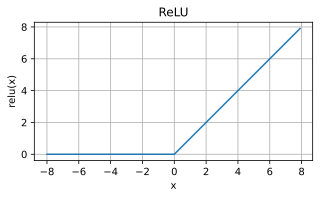

In [48]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt

# 定义输入范围为-8到8之间的张量
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)

# 计算ReLU函数的输出
y = torch.relu(x)

# 创建图形，并指定大小
plt.figure(figsize=(5, 2.5))

# 绘制ReLU函数的图像
plt.plot(x.detach(), y.detach(), '-')

# 添加x轴和y轴标签
plt.xlabel('x')
plt.ylabel('relu(x)')

# 添加标题
plt.title('ReLU')

# 添加网格线
plt.grid(True)

# 显示图形
plt.show()


### Grad of Relu

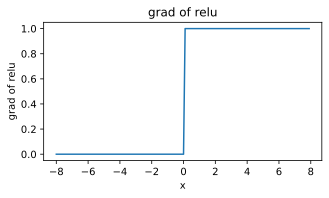

In [49]:
# 定义输入范围为-8到8之间的张量
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)

# 计算ReLU函数的输出
y = torch.relu(x)

# 对y进行反向传播，计算梯度
y.backward(torch.ones_like(x), retain_graph=True)

# 创建图形，并指定大小
plt.figure(figsize=(5, 2.5))

# 绘制ReLU函数的图像
plt.plot(x.detach(), x.grad, '-')

# 添加x轴和y轴标签
plt.xlabel('x')
plt.ylabel('grad of relu')

# 添加标题
plt.title('grad of relu')

# 显示图形
plt.show()

### Grad of Sigmod 

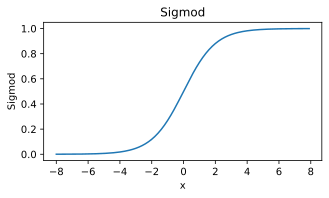

In [50]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
# 计算ReLU函数的输出

y = torch.sigmoid(x)
    
# 创建图形，并指定大小
plt.figure(figsize=(5, 2.5))

# 绘制ReLU函数的图像
plt.plot(x.detach(), y.detach(), '-')

# 添加x轴和y轴标签
plt.xlabel('x')
plt.ylabel('Sigmod')

# 添加标题
plt.title('Sigmod')

# 显示图形
plt.show()

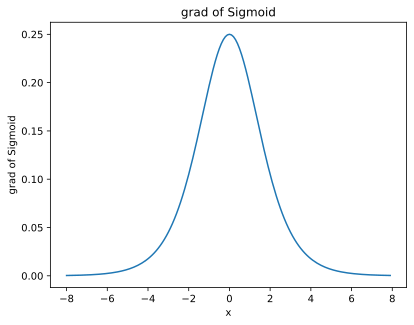

In [51]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x), retain_graph=True)
x.grad.data.zero_()
y.backward(torch.ones_like(x), retain_graph=True)

plt.plot(x.detach(), x.grad.detach(), '-')  # 使用 '-' 参数指定线性样式

plt.xlabel('x')
plt.ylabel('grad of Sigmoid')
plt.title('grad of Sigmoid')
plt.show()

###  tanh

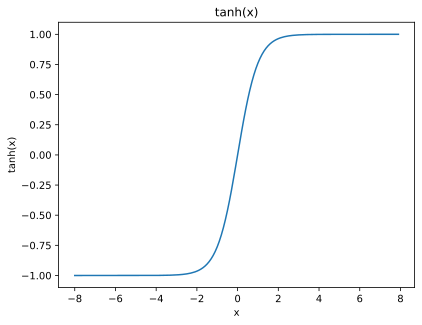

In [52]:
y = torch.tanh(x)
        
plt.plot(x.detach(), y.detach(), '-')  # 使用 '-' 参数指定线性样式

plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.title('tanh(x)')
plt.show()

###  Grad of tanh

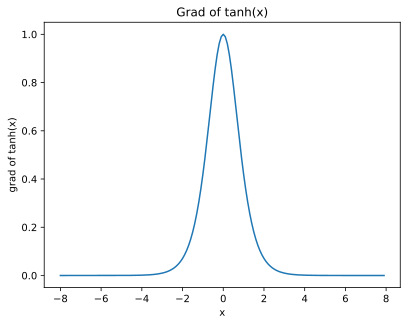

In [53]:
# 清除以前的梯度
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
plt.plot(x.detach(), x.grad, '-')  # 使用 '-' 参数指定线性样式

plt.xlabel('x')
plt.ylabel('grad of tanh(x)')
plt.title('Grad of tanh(x)')
plt.show()

## MLP from zero to start

In [54]:
import torch
from torch import nn

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

### Init the model parameters

In [55]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

### Customerize Relu

In [56]:

def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

### Model

In [57]:
## reshape to transform the 2D image to a length as num_inputs
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)  # 这里“@”代表矩阵乘法
    return (H@W2 + b2)

### Loss Function

In [58]:
loss = nn.CrossEntropyLoss(reduction='none')

### Train

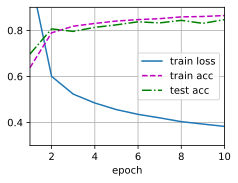

In [59]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

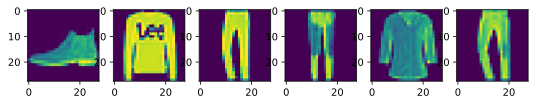

In [63]:
predict_ch3(net, test_iter)